# Nike vs. Adidas shoes EDA

#### by: Moiezali Ismail

dataset provided by [Kash on kaggle](https://www.kaggle.com/datasets/kaushiksuresh147/adidas-vs-nike)

## Introduction
### 1. The Context
Adidas and Nike, two titans in the sportswear industry, have long been at the forefront of innovation, style, and marketing. While both brands enjoy global recognition and a strong customer base, there is an ongoing debate regarding their market positioning, customer preferences, and brand perception. Understanding the nuances of this rivalry is crucial for stakeholders in the sportswear market, as it sheds light on consumer behavior and emerging trends.

### 2. The Objective
The primary goal of this analysis is to conduct a comprehensive comparison between Adidas and Nike, focusing on aspects such as market share, product innovation, brand strategies, and customer loyalty. This project aims to unravel the factors that define the competitive edge for each brand and how they resonate with their respective consumer demographics. Insights from this analysis are intended to inform marketing strategies and product development in the sportswear sector.

### 3. The Key Questions
- What are the differences between the numerical variables(Price, Discount, Rating, and Sale price)between the two giants in the current market?
- Is there any correlation between rating and listing price or any other variables? If so, to what degree?

# Table of contents

#### Table of contents: 
- [Initial observations](#Initial-observations)
- [Data cleaning](#Data-cleaning)
- [Data cleaning summary](#Data-cleaning-summary)
- [Analysis](#Analysis)
- [Exporting to cloud](#Exporting-to-cloud) 
- [Insights + recommendations](#Insights-and-recommendations) 
- [Conclusion](#Conclusion)

In [2]:
import plotly.io as pio
pio.renderers.default = "svg"
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import pearsonr, uniform, norm, t, shapiro, mannwhitneyu, ranksums
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

In [3]:
data = pd.read_csv('/Users/moiezismail/projects/shoes/raw shoes.csv')

## Initial observations

In [4]:
# 5 random observations to have a random look at the data
data.sample(5)

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Description,Rating,Reviews,Last Visited
1141,Men's adidas Sport Inspired Arcadeis Shoes,CL7427,4599,2299,50,Adidas CORE / NEO,These men's running-inspired shoes cradle your...,3.20,64,2020-04-13T15:07:00
1121,WOMEN'S ADIDAS ORIGINALS SAMBAROSE SHOES,AQ1134,7999,4799,40,Adidas ORIGINALS,These sneakers rework the Samba's classic socc...,3.60,0,2020-04-13T15:06:59
1669,Men's adidas Running PulseBoost HD Ltd Shoes,G26990,14999,10499,30,Adidas SPORT PERFORMANCE,"We believe that feet deserve a runner's high, ...",2.50,65,2020-04-13T15:07:23
3110,Nike Air Max 270,AH6789-023,0,13995,0,Nike,The Nike Air Max 270 is inspired by two icons ...,3.90,63,2020-04-13T15:35:06
1558,Women's adidas Sport Inspired Questar Summer S...,F36512,5599,2799,50,Adidas CORE / NEO,Take on the heat. The airy mesh build of these...,3.40,36,2020-04-13T15:07:16


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product Name   3268 non-null   object 
 1   Product ID     3268 non-null   object 
 2   Listing Price  3268 non-null   int64  
 3   Sale Price     3268 non-null   int64  
 4   Discount       3268 non-null   int64  
 5   Brand          3268 non-null   object 
 6   Description    3265 non-null   object 
 7   Rating         3268 non-null   float64
 8   Reviews        3268 non-null   int64  
 9   Last Visited   3268 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 255.4+ KB


In [6]:
data.nunique()

Product Name     1531
Product ID       3179
Listing Price      78
Sale Price        227
Discount            6
Brand               5
Description      1762
Rating             32
Reviews           102
Last Visited      318
dtype: int64

In [7]:
# a 0-rating doesn't make sense so I will impute the average 
(data['Rating']==0).sum()

302

## Summary of initial observations

1. So the data is quite limited as we do not have a sales count variable which we can predict or use for linear regression prediction
2. The variables that do not have explanatory power are: Product name, Product ID, Reviews, Description, and Last visited. Brand will be useful to create a column for company, but it's also useless. 
3. There are 3268 entries with the Description column missing only 3 entries(null)
4.  The listing and sale price is without a decimal, so the interger value is in the tens of thousands. That would skew results later on. 
5. Nike has products with listing price as 0(non-null missing value) but a sale price which would skew analysis and aggregation 
6. Reviews are a count rather than a score 
7. Ratings column has many non-null missing values i.e. 0s which skew aggregation
8. Discount is a % rather than an absolute value in $, and discreet so that will affect scatterplots
9. Out of the data dataframe, I will create 2 others: Nike and Adidas for easier summar stats

## Data cleaning 

In [8]:
## Remove duplicates 
data.drop_duplicates(subset=['Product ID', 'Product Name'], inplace=True)

# Dropping the irrelevant columns
data.drop(columns=['Last Visited', 'Reviews'], inplace=True)

In [9]:
# change listing price and sale price into float with decimal for correct price format
def convert_to_float(x):
    return x / 100.0

# Apply the function to the "Listing Price"
data['Listing Price'] = data['Listing Price'].apply(convert_to_float)
data['Sale Price'] = data['Sale Price'].apply(convert_to_float)


In [10]:
data.sample(2)

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Description,Rating
2230,Men's Sport Inspired Streetmighty Shoes,EG4344,59.99,59.99,0,Adidas CORE / NEO,Make your presence known without saying a word...,4.70
898,Women's ADIDAS ORIGINALS GAZELLE STITCH AND TU...,BB6708,89.99,44.99,50,Adidas ORIGINALS,"Built with superior craftsmanship, these kicks...",2.60


Observation: 

The discount is in % form so let's add that to the column title

In [11]:
data.rename(columns={'Discount': 'Discount %', 'Product ID':'Product_ID'}, inplace=True)

In [12]:
# Count the number of Nike products vs. Adidas
nike_prods = sum(data["Brand"].str.contains("Nike", case=True))
adidas_prods = 3268 - nike_prods

f"Nike products:{nike_prods} and Adidas products:{adidas_prods} so abbout 75% more products adidas products than Nike" 


'Nike products:554 and Adidas products:2714 so abbout 75% more products adidas products than Nike'

In [13]:
#Create a column with object dtype with products labelled as Nike or Adidas and DROP the brand column

data['Company'] = data['Brand'].apply(lambda x: 'Nike' if
                                      'Nike' in x else 'Adidas' if 'Adidas' in x else 'Other')
data.drop('Brand', axis=1, inplace=True)

In [14]:
# Check to see if there are only 2 different values in the Company column as intended 
data.nunique()

Product Name     1531
Product_ID       3179
Listing Price      78
Sale Price        227
Discount %          6
Description      1762
Rating             32
Company             2
dtype: int64

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Listing Price,3179.00,69.91,46.76,0.00,45.99,59.99,89.99,299.99
Sale Price,3179.00,60.26,41.92,4.49,29.99,45.99,79.95,365.00
Discount %,3179.00,27.63,22.49,0.00,0.00,40.00,50.00,60.00
Rating,3179.00,3.27,1.39,0.00,2.60,3.50,4.40,5.00


**Observation** 
1. The mean for listing and sale price does not make sense so we'll have to fix those column values

### Non-null missing values i.e. When 0 != not a score

#### As expected, the Nike data has missing non-null values for listing price; we'll have to impute them as listing price if it's 0. 

In [16]:
# Create a boolean mask for rows where 'Listing Price' is 0
zero_rows = (data['Listing Price'] == 0)

# Use boolean indexing to update the values in 'Listing Price' and 'Sale Price' columns
data.loc[zero_rows, 'Listing Price'] = data.loc[zero_rows, 'Sale Price']
data.loc[zero_rows, 'Sale Price'] = 0

In [17]:
data.sample(3)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company
2173,Men's adidas Originals Spezial Handball Shoes,DB3021,79.99,47.99,40,This low-profile style was originally built to...,3.80,Adidas
77,Men's adidas Swim Ozor III Slippers,CM0057,12.99,7.79,40,The simple and stylish adidas Ozor III slipper...,2.20,Adidas
1752,Men's adidas Originals Liberty Cup Shoes,EE6110,75.99,45.59,40,Late-'90s tennis style broke with everything t...,5.00,Adidas


#### impute the % discount if Nike products have a different listing price than sale price excluding zero

In [18]:
data['Discount %'] = data.apply(lambda row: 
                            (row['Listing Price'] - row['Sale Price']) / row['Listing Price'] 
                            * 100 if row['Sale Price'] != 0 else 0, axis=1)

#Round the % to a whole number for neater analysis
data[['Listing Price','Sale Price','Discount %']] = np.round(data[['Listing Price','Sale Price','Discount %']])

# Impute the Sale Price with Listing Price where Discount % is 0
data.loc[data['Discount %'] == 0, 'Sale Price'] = data['Listing Price']

In [19]:
data.sample(3)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company
1786,Men's adidas Originals U_Path Run Shoes,G27636,80.00,80.00,0.00,The U_Path Run offers a sleek combination of r...,2.90,Adidas
105,Men's adidas Toe Side II Slippers,CM0069,13.00,8.00,40.00,The adidas casual sandals for men with a strik...,3.00,Adidas
1652,Men's adidas Swim Coset II Slippers,CM6068,15.00,15.00,0.00,The simple and stylish adidas Stabile slippers...,3.90,Adidas


#### Turn non-null missing values(i.e. 0) into NaN then perform an aggregation to calculate the mean then impute that value into the NaN cells

In [20]:
data['Rating'] = data['Rating'].replace(0, np.nan)

In [21]:
# impute the mean rating for all cells which have 0 
data['Rating'] = data['Rating'].apply(lambda x: x if x != 0 else np.nan).fillna(data['Rating'].mean())

In [22]:
data[['Listing Price', 
      'Sale Price', 
      'Discount %']] = data[['Listing Price', 
                             'Sale Price',
                             'Discount %']].fillna(0).astype('int64')

In [23]:
# 0 as a Sale price does not make sense as shoes cannot be discounted to the point of being free 
# keeping 0 will affect the aggregations and analysis so turn all Sale Price == 0 as NaN

data['Sale Price'].replace(0, np.nan, inplace=True)

In [24]:
data.sample(5)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company
405,Women's adidas Running Sooraj Shoes,EG4006,56,56,0,Fast and sleek. Ready to go. These women's run...,3.90,Adidas
1160,Men's adidas Sport Inspired Lite Racer Slip-Ons,F36664,40,20,50,A streamlined slip-on. These shoes simplify a ...,4.10,Adidas
480,Men's adidas Sport Inspired Archivo Shoes,EF0440,56,34,40,Modern comfort and authentic adidas heritage m...,3.70,Adidas
732,WOMEN'S ADIDAS ORIGINALS NMD_CS1 PRIMEKNIT SHOES,AQ1136,150,75,50,These women's shoes combine advanced technolog...,3.40,Adidas
1275,UNISEX ADIDAS ORIGINALS SKATEBOARDING 3MC SHOES,B22705,60,36,40,"Combining skate-friendly design with a clean, ...",3.56,Adidas


## Feature engineering

### value score :
rating / listing price which means that the higher the value, the better the deal based on rating vs. price

In [25]:
data['value'] = round(data['Listing Price'] / data['Rating'])

#### Setting the product id as the index

In [26]:
data.sample(3)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company,value
2714,Nike Mercurial Superfly 7 Elite SE FG,CD6721-808,230,230,0,Building on the 360-degree Flyknit innovation ...,3.56,Nike,65.00
1394,Men's Originals Skateboarding Seeley Shoes,F37427,60,60,0,Old-school skate style graduates to a new look...,4.40,Adidas,14.00
1708,Men's adidas Originals Continental 80 Shoes,EH0173,80,80,0,"Steeped in nostalgia, the Continental 80 captu...",2.90,Adidas,28.00


In [27]:
shoes = data.copy()

In [28]:
# Reordering the columns 
shoes = shoes.reindex(columns=['Product_ID',
                                         'Product Name', 
                                         'Company','Listing Price',
                                         'Sale Price','Rating',
                                         'Discount %',
                                         'value','Description'])

In [29]:
shoes.sample(3)

,Product_ID,Product Name,Company,Listing Price,Sale Price,Rating,Discount %,value,Description
434,CL7604,Men's adidas Running Erish Shoes,Adidas,43,21,2.80,50,15.00,Energize your run while staying comfortable wi...
371,CK9714,Women's adidas Running Bolter Shoes,Adidas,43,21,2.00,50,22.00,These women's running shoes keep you comfortab...
155,EE4945,Women's adidas Originals I-5923 Shoes,Adidas,120,72,3.40,40,35.00,These lightweight street shoes offer a shout-o...


In [30]:
shoes.isnull().sum()

Product_ID       0
Product Name     0
Company          0
Listing Price    0
Sale Price       0
Rating           0
Discount %       0
value            0
Description      3
dtype: int64

## Data Cleaning Summary:
1. Eliminated duplicate entries based on 'Product_ID' and Product name.
2. Excluded non-essential columns 'Last Visited' and 'Reviews'.
3. Converted 'Listing Price' and 'Sale Price' into floats to ensure accurate price representation.
4. Renamed 'Discount' to 'Discount %' and 'Product ID' to 'Product_ID' for consistency.
5. Evaluated and noted a predominance of Adidas products in the dataset.
6. Created a 'Company' column to replace the original 'Brand' column for clear brand identification.
7. Validated that the 'Company' column contained only two distinct values: 'Nike' and 'Adidas'.
8. Corrected 'Listing Price' entries of 0 by substituting them with 'Sale Price' values.
9. Updated 'Discount %' where 'Sale Price' varied from 'Listing Price'.
10. Rounded 'Listing Price', 'Sale Price', and 'Discount %' to integers for a tidier presentation.
11. Transformed 'Rating' zeroes to NaN and filled with the mean of existing ratings.
12. Changed the data type of price-related columns to integer for uniformity and simplified analysis.
13. Assigned NaN to 'Sale Price' figures of 0 to prevent distortion in subsequent analyses.
14. Marked 'Discount %' entries of 0 as NaN to accurately reflect the absence of discounts.
15. Introduced a 'value' metric by dividing 'Listing Price' by 'Rating' to gauge value for money.
16. Rearranged columns for an optimized data structure and designated 'Product_ID' as the index.

### Limitations of the dataset : 
Before we get started on the analysis, I want to go over a few things: 

1. The dataset lacks a continuous target variable such as sales, or profits/losses, and geographic data(Store/countries where those sales occured) which limited inferential analysis for performance between Nike and Adidas. 

2. There were far more Adidas products than Nike which significantly affected affected count plot/analysis, so we had to compare everything in averages 

3. Since none of the variables were normally distributed, it was difficult to perform tests like t-tests, ANOVA etc. between the means of Nike vs. Adidas.

### Export data to csv

In [31]:
shoes.to_csv('shoes.csv', index=False)

## Data exported out to Google Cloud Platform(GCP) for use in BigQuery

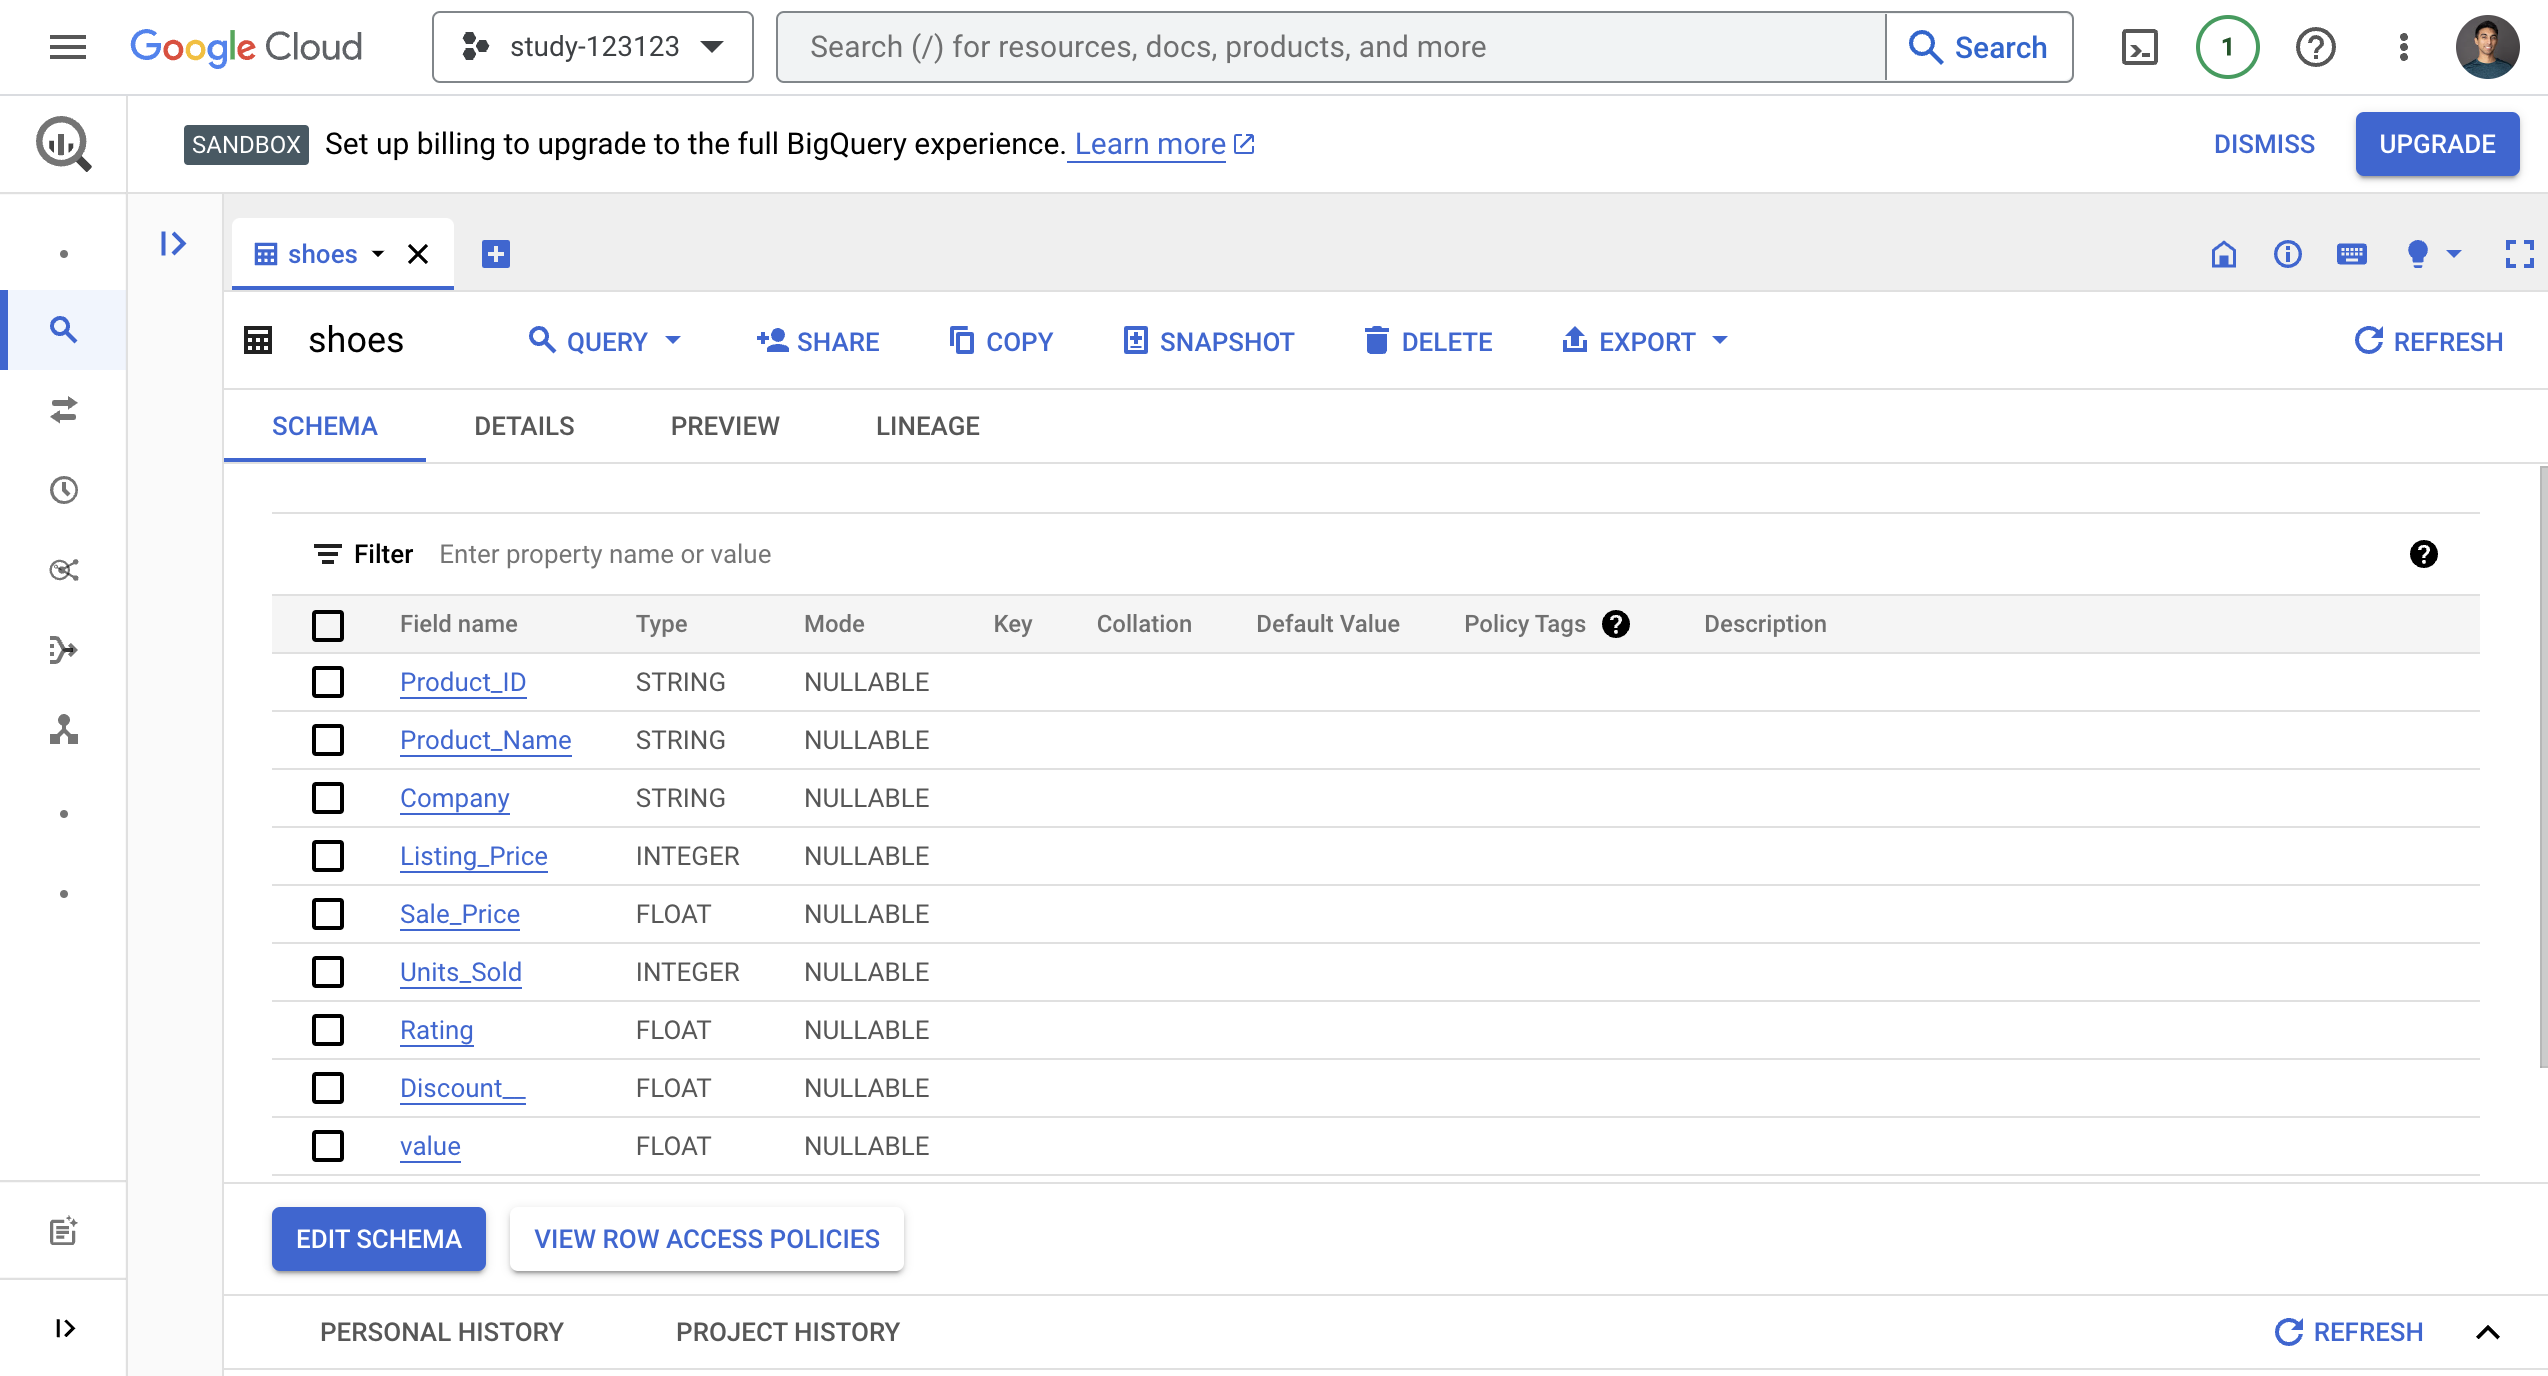

## Analysis

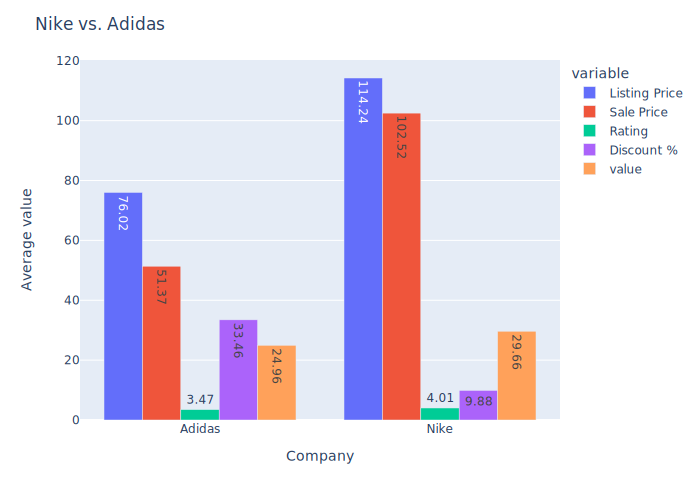

In [32]:
#　A quick glance at the average of the numerical columns for both Nike and Adidas 
company_avg = shoes.groupby('Company').mean()

fig_comp = px.bar(company_avg, barmode='group')

fig_comp.update_traces(texttemplate='%{y:.2f}', textposition='auto') # round the y-values to 2 decimal places

fig_comp.update_layout(title="Nike vs. Adidas", 
                  xaxis_title="Company", yaxis_title='Average value')

#### Observations: Nike vs. Adidas
1. Nike shoes, on average, cost almost $40 more and have 0.66 points higher rating
2. Nike's average sale price is about 30 USD higher
3. Adidas gives higher discounts on average than Nike
4. Adidas however has a higher value ratio than Nike

In [33]:
# Creating subsets of the data filtered by company
nike = shoes[shoes['Company'] == 'Nike']
adidas = shoes[shoes['Company'] == 'Adidas']

In [34]:
np.round(nike.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Listing Price,554.00,114.24,43.23,16.00,80.00,110.00,150.00,365.00
Sale Price,554.00,102.52,42.69,16.00,72.00,100.00,129.50,365.00
Rating,554.00,4.01,0.73,1.00,3.56,3.90,4.60,5.00
Discount %,554.00,9.88,14.33,0.00,0.00,0.00,20.00,40.00
value,554.00,29.66,14.41,4.00,21.00,28.00,36.00,170.00


In [35]:
np.round(adidas.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Listing Price,2625.00,76.02,40.71,9.00,50.00,66.00,90.00,300.00
Sale Price,2625.00,51.37,35.90,4.00,28.00,40.00,65.00,300.00
Rating,2625.00,3.47,1.01,1.00,2.80,3.56,4.30,5.00
Discount %,2625.00,33.46,20.43,0.00,0.00,40.00,50.00,60.00
value,2625.00,24.96,18.57,2.00,13.00,20.00,31.00,230.00


#### Observations

1. The highest priced shoe is from Nike at 365 USD, while the lowest priced shoe is from Adidas at 9 USD.
2. Nike's interquartile range is 70 USD, which is significantly higher than Adidas's interquartile range of 40 USD.
3. Both Nike and Adidas shoes share the same minimum and maximum ratings, suggesting that customers rate both brands similarly at both extremes.

<AxesSubplot: >

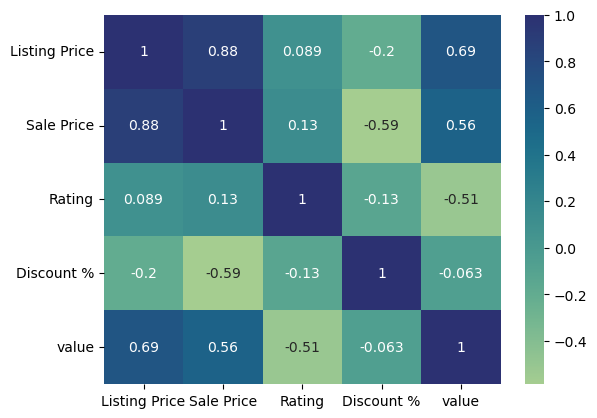

In [36]:
# Correlation matrix for the numerical variables for both Nike and Adidas combined

sns.heatmap(data=shoes.corr().T, annot=True, cmap='crest')

#### Observations: 
1. There is a strong correlation between Listing Price and Sale Price 
2. There is a moderate correlation between Sale price and Rating. 
3. And as expected, there is a correlation(although weak) between rating and value ratio

# Univariate analysis:

We'll have a look at the 3 following variables' distribution: 
1. Listing price
2. Discount %
3. Rating

#### 1. Is there a difference in the average Listing price between Nike and Adidas shoes?

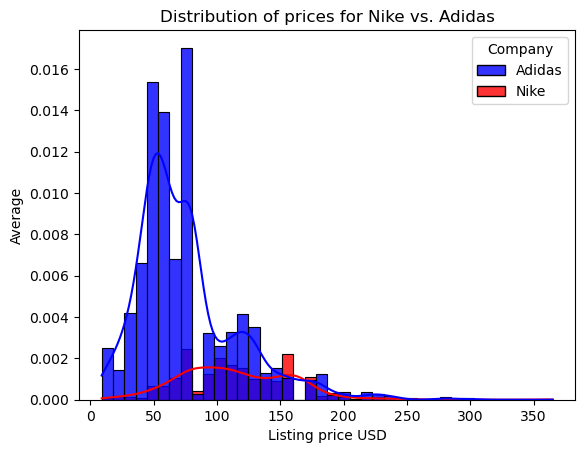

In [37]:
palette = {"Nike": "red", "Adidas": "blue"}

sns.histplot(data=shoes, x="Listing Price", hue="Company", kde=True, 
             bins=40, alpha=0.8, stat='density', palette=palette)

plt.title("Distribution of prices for Nike vs. Adidas")
plt.xlabel("Listing price USD")
plt.ylabel("Average")
plt.show()

**Observations** 
1. Both distributions seem to be quite right-skewed indicating outliers in the upper-end for prices
2. Adidas's mean around 50 dollars whereas Nike has a higher distribution around 80
2. We'll have to divide the listing price into 3 categories for better analysis and visualization later on for bivariate analysis

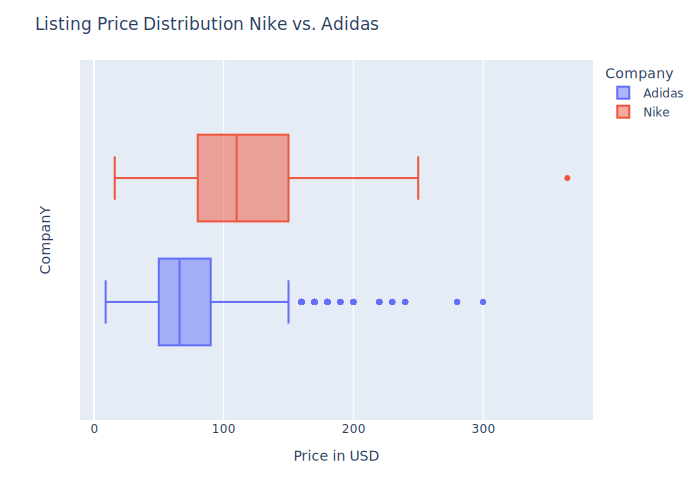

In [38]:
# Another perspective  
fig = px.box(shoes, x="Listing Price", color='Company')

fig.update_layout(title="Listing Price Distribution Nike vs. Adidas", 
                  xaxis_title="Price in USD",
                  yaxis_title="CompanY")
fig.show()

**Observations**
1. There seems to be a right-skew for the listing price for both Nike and Adidas so it's not normally distributed , we'll have to 1st conduct a Shapiro test to check for normality
2. Adidas prices far more outliers

State the hypothesis:
* $H_0:$ There is no skewness between the two company's average listing prices, it's normally distributed
* $H_1:$ There is skewness between the two company's average listing prices, it's not normally distributed

alpha = 0.05

In [39]:
adidas_price = shoes[shoes['Company'] == 'Adidas']['Listing Price']
nike_price = shoes[shoes['Company'] == 'Nike']['Listing Price']

In [40]:
# Both p-values from the test are printed in this tuple  
((shapiro(adidas_price)[1])),((shapiro(nike_price))[1])

(2.322922655221999e-39, 2.641280971715787e-09)

**Conclusion**
1. We can conclude that both Nike and Adidas Listing prices are not normally distributed. 
2. Because the data is not normally distributed, we'll have to perform the Mann-Whitney U test to compare the means of the listing prices between the two companies

#### Question 1 : Is there a significant difference between Nike and Adidas's average listing price? 

State the hypothesis:
* $H_0:$ There is no difference between the two company's average listing price
* $H_1:$ there is a difference between the two company's average listing price

alpha = 0.05

The Mann-Whitney U test is a non-parametric statistical test used to determine whether two independent samples come from populations with the same distribution. It is also known as the Mann-Whitney-Wilcoxon test or the Wilcoxon rank-sum test.

In [41]:
# This function will compare the prices of both companies to see if the average is statistically different
def compare_listing_price(data):
    stat, p = stats.mannwhitneyu(nike_price, adidas_price, alternative='two-sided')
    alpha = 0.05
    
    if p < alpha:
        print("Since the p-value of the test is less than an alpha of 0.05, we can reject the null hypothesis.")
    else:
        print("Since p-value is not lower than the alpha, we have failed to reject the null.")

compare_listing_price(data=data)

Since the p-value of the test is less than an alpha of 0.05, we can reject the null hypothesis.


**Conclusion** : The average listing price is significantly different for both Nike and Adidas

#### Distribution of discount %

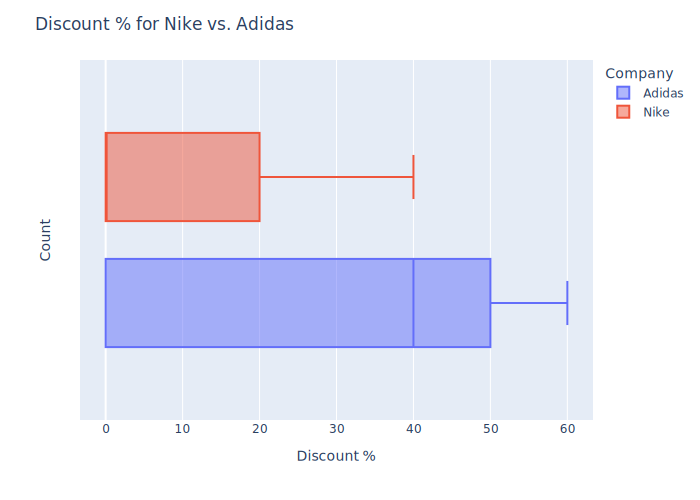

In [42]:
fig = px.box(shoes, x="Discount %", color='Company')

fig.update_layout(title="Discount % for Nike vs. Adidas", 
                  xaxis_title="Discount %",
                  yaxis_title="Count")
fig.show()


**Observations** 
Nike has a much lower discount % distribution, with the highest value going up to 40% whereas Adidas has a larger distribution with the interquartile range between 40 and 50 and highest % at 60 meaning Adidas is more generous with their discounts

#### We can visually see that there is a diff, but let's test whether or not the Discounts are normally distributed

State the hypothesis:
* $H_0:$ The Discount % is normally distributed
* $H_1:$ The Discount % is NOT normally distributed

alpha = 0.05

In [43]:
nike_disc = shoes.loc[shoes['Company'] == 'Nike','Discount %']
adidas_disc = shoes.loc[shoes['Company'] == 'Adidas','Discount %']

print(((stats.shapiro(nike_disc))[1],
 (stats.shapiro(adidas_disc))[1]))

print("We failed to reject the null meaning both discount % are normally distributed")

(5.1401283464282075e-31, 0.0)
We failed to reject the null meaning both discount % are normally distributed


#### observation: 
- having discounts normally distributed means that most of the discounts are in the interquartile range

#### Let's have a look at the Rating distribution for both companies

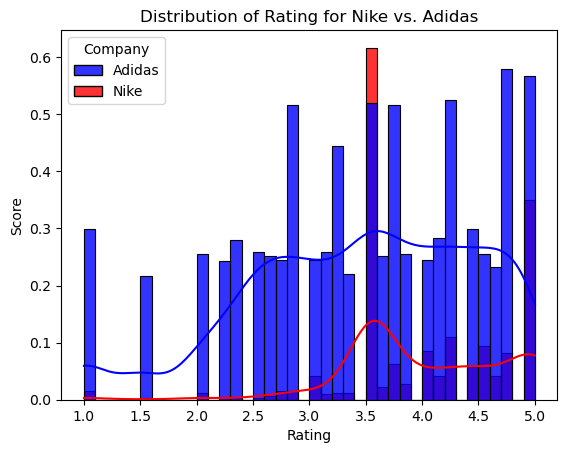

In [44]:
sns.histplot(data=shoes, x="Rating", hue="Company", kde=True, 
             bins=40, alpha=0.8, stat='density',
            palette = {"Nike": "red", "Adidas": "blue"})

plt.title("Distribution of Rating for Nike vs. Adidas")
plt.xlabel("Rating")
plt.ylabel("Score")
plt.show()

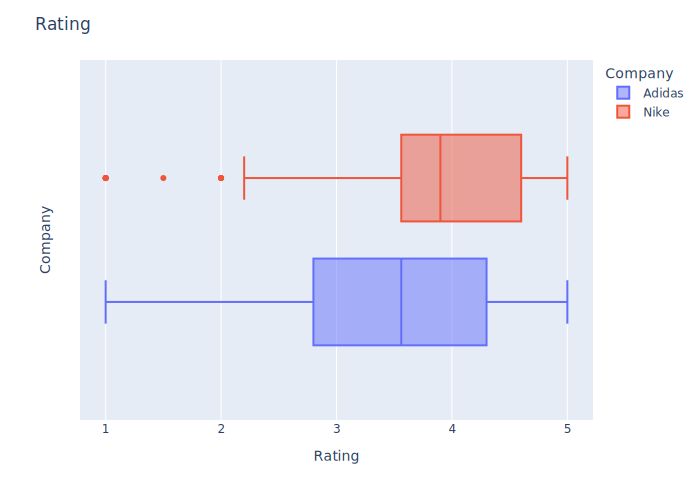

In [45]:
# Another perspective to see the distribution 
fig = px.box(shoes, x="Rating", color='Company')

fig.update_layout(title="Rating", 
                  xaxis_title="Rating",
                  yaxis_title="Company")
fig.show()


**Observations**

1. Opposite to the discount %, Nike has a left skewed distribution where the Median is much closer to the 1st quartile indicating many values towards the higher end whereas addias seems to hold the same type of distribution that it had for the discount %. 
2. The whiskers for Nike are a smaller than Adidas(which has a much large range)

#### We can visually see that there is a diff, but let's test whether or not the Ratings are normally distributed using a stat test

State the hypothesis:
* $H_0:$ The Rating are normally distributed
* $H_1:$ The Rating is NOT normally distributed

alpha = 0.05

In [46]:
nike_rating = shoes.loc[shoes['Company'] == 'Nike','Rating']
adidas_rating = shoes.loc[shoes['Company'] == 'Adidas','Rating']

((stats.shapiro(nike_rating))[1],
 (stats.shapiro(adidas_rating))[1])

(3.2002635622699234e-20, 4.5152885204286405e-26)

**Conclusion** 
1. Based on the Shapiro-Wilk test for normality, we can conclude that neither Nike nor Adidas's ratings are normally distributed. 

## Bivariate analysis

**Observations** 
1. Listing price vs. Rating: Nike is concentrated near the higher rating whereas Adidas is closer to the bottom ratings
2. Sale price shows the same distribution as listing price so no surprises there. 
3. Since discount is not continuous, we get straight lines with Nike giving smaller discounts than Adidas
4. For the most part, the lower end of the ratings are similar, but there is a sharp increa for Nike towards the higher end of ratings for shows unlike Adidas which remains stable

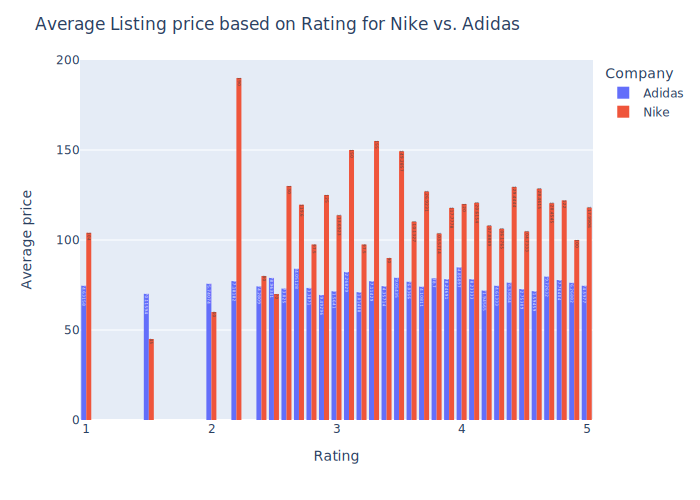

In [47]:
fig4 = px.histogram(shoes, x="Rating", y="Listing Price",
             color='Company', barmode='group',
             text_auto=True, histfunc='avg')

fig4.update_layout(title="Average Listing price based on Rating for Nike vs. Adidas", 
                  xaxis_title="Rating",
                  yaxis_title="Average price")

**Observations** 
1. Not surprisingly Nike has on average, higher-rated, higher-priced shoes than Adidas

#### Question: Is there a correlation between listing price and rating? 

State the hypothesis:
* $H_0:$ There is no correlation between Listing price and Rating
* $H_1:$ There is a correlation between Listing price and Rating

alpha = 0.05

In [48]:
stats.pearsonr(shoes['Rating'], shoes['Listing Price'])

PearsonRResult(statistic=0.0893035877034872, pvalue=4.5764492777959445e-07)

**Conclusion**
1. Based on a weak correlation coefficient of 0.097, and a p-value much lower than our alpha we have enough evidence to reject the null and say that that there is a correlation between listing price and rating albeit an extremely weak one so rating only slightly increase as price increases. 

<AxesSubplot: xlabel='value', ylabel='Listing Price'>

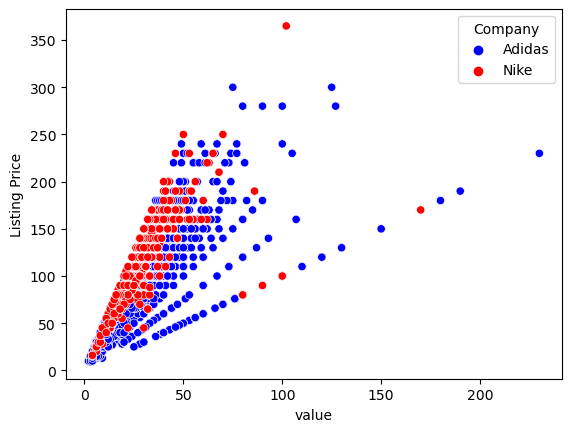

In [49]:
sns.scatterplot(data=shoes, x='value',
                y='Listing Price',
                hue='Company',
                palette=palette)

### Observation:
1. Overall, Adidas is providing more value per USD based on its rating than Nike
2. This graph and insight is a little skewed as there are many more Adidas shoes analyzed than Nike
3. There are no Nike shoes with a higher value ratio than 0.3 whereas Adidas does 

### Question : Is there a difference in the average of Ratings between Nike and Adidas? 

* $H_0:$ There is no difference in the mean Rating between Nike and Adidas
* $H_1:$ Nike and Adidas have statistically different means in their Ratings

alpha = 0.05

Since the ratings are not normally distributed, we cannot perform a two-sided t-test so we will have to perform the Wilcoxon ranksum test 

In [50]:
from scipy.stats import ranksums

rating_means = statistic, pvalue = ranksums(nike_rating, adidas_rating)

print(f'The p-value is less than alpha at {rating_means[1]} so there is a difference in the average of ratings')

The p-value is less than alpha at 2.6469718143185273e-32 so there is a difference in the average of ratings


#### Conclusion: 

Since p-value for both the Leven's test and the Shapiro-Wilk test is lower than the alpha of 0.05, neither the variance is equal, nor is the data normally distributed so we CANNOT perform the t-test to check for difference in means

#### Question: What portion of Nike and Adidas shoes are rated at least a 4.0? 

In [51]:
# Flag shoes which are rated 4.0 or higher 
shoes['Top Rated'] = shoes['Rating'] >= 4

top_rated_percentage = round(shoes.groupby('Company')['Top Rated'].mean() * 100).to_frame()
print(top_rated_percentage)

         Top Rated
Company           
Adidas       36.00
Nike         49.00


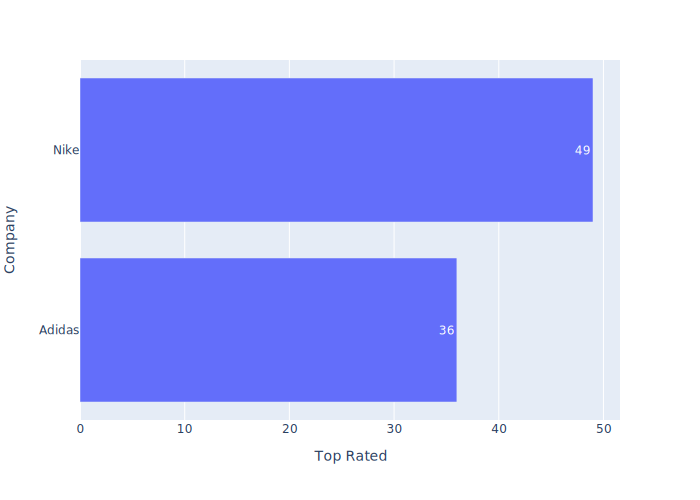

In [52]:
px.bar(top_rated_percentage, x='Top Rated', text_auto=True)

## Regression analysis
- The prevailing assumption is that the quality of shoes correlates with their price and consequently influences customer ratings. However, the potent brand image and marketing of powerhouses like Nike and Adidas may override this assumption. Despite the quality or actual customer satisfaction, these brands might be able to command higher prices and receive favorable ratings based on their reputation alone. Thus, in analyzing the relationship between listing price and ratings, it is postulated that higher prices may lead to higher ratings, not necessarily due to the product's quality but potentially due to the perceived value and customer loyalty fostered by the brands' marketing strategies

In [55]:
# isolate the variables for regression
X1 = shoes['Listing Price']
y1= shoes['Rating']

X1 = sm.add_constant(X1)

reg1 = sm.OLS(y1, X1).fit()

shoes['best_fit1'] = reg1.predict(X1)

# Print out the R^2 value
print(f"R^2: {reg1.rsquared}")

R^2: 0.007975130776714634


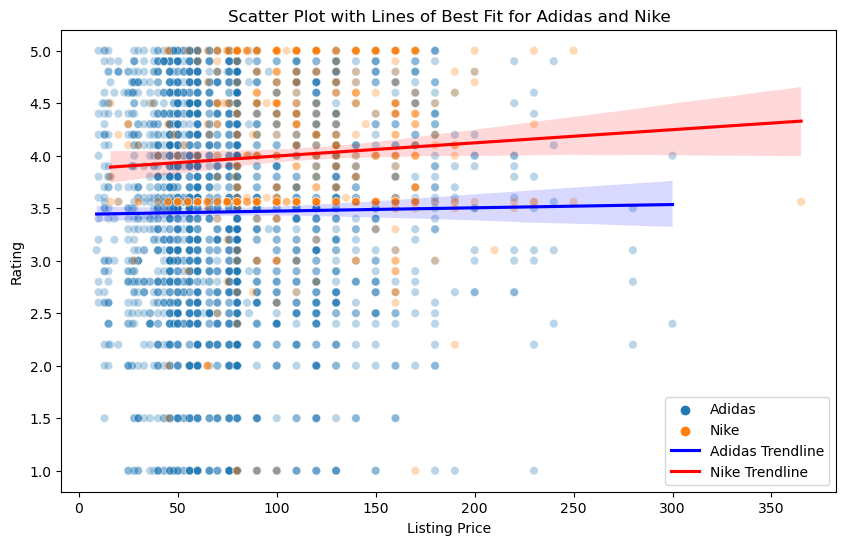

In [58]:
# Filter the DataFrame for Adidas and Nike
shoes_adidas = shoes[shoes['Company'] == 'Adidas']
shoes_nike = shoes[shoes['Company'] == 'Nike']

# Scatter plot with Seaborn including all data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=shoes, x='Listing Price', y='Rating', hue='Company', alpha=0.3)

# Regression line for Adidas
sns.regplot(data=shoes_adidas, x='Listing Price', y='Rating', scatter=False, color='blue', label='Adidas Trendline')

# Regression line for Nike
sns.regplot(data=shoes_nike, x='Listing Price', y='Rating', scatter=False, color='red', label='Nike Trendline')

# Add title and labels as needed
plt.title('Scatter Plot with Lines of Best Fit for Adidas and Nike')
plt.xlabel('Listing Price')
plt.ylabel('Rating')

# Show the plot
plt.legend()
plt.show()

#### observations: 
- The regression analysis yields an $R^2$ value of approximately 0.008, indicating that the listing price accounts for merely 0.8% of the variance in shoe ratings. This weak correlation suggests that factors other than price, perhaps brand image or other attributes not captured in the dataset, are more influential in determining customer ratings for Nike and Adidas shoes. Such findings underscore the potent impact of brand equity on consumer perceptions.
- The **Adidas trendline** is positioned slightly above the Nike trendline, suggesting a marginally higher average rating for Adidas products. For instance, at a listing price of \$100, the Adidas trendline indicates a rating close to 3.5, whereas Nike's is approximately 3.4.
- Both brands' products are densely populated in the \$50 to \$100 price range, indicating a high concentration of products in this segment. Within this range, ratings for both brands are distributed between approximately 3.0 and 4.5.
- The **confidence interval** for Nike's ratings, represented by the red shaded area, is broader than Adidas', particularly at higher price points. This suggests more variation in customer ratings for Nike's products as the price increases.

In [54]:
shoes.isnull().sum()

Product_ID       0
Product Name     0
Company          0
Listing Price    0
Sale Price       0
Rating           0
Discount %       0
value            0
Description      3
Top Rated        0
best_fit1        0
dtype: int64

In [59]:
X2 = shoes['Rating']
y2 = shoes['Discount %']

X2 = sm.add_constant(X2)

reg2 = sm.OLS(y2, X2).fit()

shoes['predicted_discount'] = reg2.predict(X2)

print(f"R^2: {reg2.rsquared}")

R^2: 0.016516892624312884


Text(0, 0.5, 'Rating')

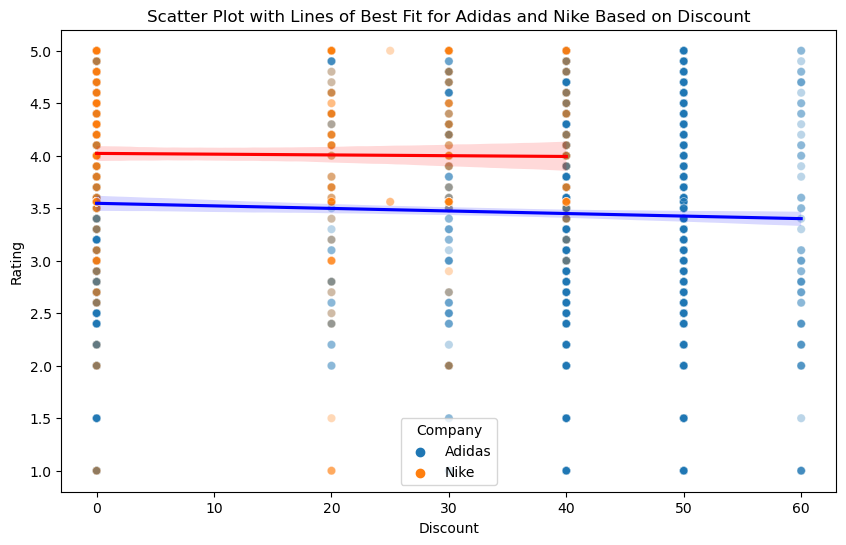

In [61]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=shoes, x='Discount %', y='Rating', hue='Company', alpha=0.3)

# Regression line for Adidas
sns.regplot(data=shoes_adidas, x='Discount %', y='Rating', scatter=False,
            color='blue', label='Adidas Trendline')

# Regression line for Nike
sns.regplot(data=shoes_nike, x='Discount %', y='Rating', scatter=False, color='red', 
            label='Nike Trendline')

# Add title and labels as needed
plt.title('Scatter Plot with Lines of Best Fit for Adidas and Nike Based on Discount')
plt.xlabel('Discount')
plt.ylabel('Rating')

#### Observation: 
- The regression analysis yields an \( R^2 \) of 0.0165, with a negative trendline slope, indicating a very weak inverse relationship between product ratings and discount percentages.
- Both **Adidas and Nike** have relatively flat lines of best fit on the scatter plot, indicating no strong linear relationship between the discounts offered and the product ratings received.
- Data points are widely spread across the range of discounts, but most product ratings are clustered between **3.0 and 5.0**, suggesting customer satisfaction is generally high regardless of the discount level.
- Adidas products are represented with discounts up to approximately **60%**, while Nike products show discounts up to about **30%**, suggesting Adidas may have a more aggressive discount strategy within this dataset.

## Insights and recommendations

Despite the limited nature of the dataset (missing sales, date, or location variables), valuable insights were still obtained. However, without these variables, in-depth recommendations on brand strategy might not be fully comprehensive. 

1. Initially, Nike appeared to have a lower average rating for their shoes than Adidas, assuming 0 is not a valid rating. Once the data was cleaned and averages were imputed, it was found that Nike shoes were consistently more expensive and higher rated than Adidas. This aligns with market trends since Nike holds a significant market share in Athleisure wear/gear.

2. Adidas's strategy of offering larger discounts could potentially be driving their sales, with some shoes receiving up to a 60% discount. In contrast, Nike might not be as dependent on this strategy, but still offers discounts, possibly to clear older models – although this is speculative. Adidas could consider elevating their brand image by creating products that directly compete with Nike and thus, justifying a higher price point. This could set off a virtuous cycle where a higher listing price contributes to perceived value, reinforcing the brand image, and enabling sustained higher pricing.

3. Both companies could possibly boost sales by offering larger discounts on their more expensive items and smaller discounts on lower-priced items. This might attract customers who are waiting for sales to purchase the higher-priced items. However, it's important to consider that offering discounts can sometimes negatively affect brand image.

## Conclusion

Based on the variables – listing price, sale price, discount %, rating, and value ratio – it is evident that Nike, on average, sells more expensive, higher-rated shoes. Adidas, on the other hand, tends to offer more generous discounts and consequently provides better value-for-price shoes. 